# Exercise 3.2

## Utility function for nicely plotting GPs

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    '''
    This function plots 95% confidence interval of GP given its parameters. It
    also plots data points and function samples if provided.
    
    Args:
        mu: mean values (n, d).
        cov: kernel matrix (n, n).
        X_train: training data points (m, d).
        Y_train: training data labels (m, 1).
        samples: list of function samples ([n, d]).
    '''
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X, mu, label='Mean')
    for i, sample in enumerate(samples):
        plt.plot(X, sample, lw=1, ls='--', label=f'Sample {i+1}')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'rx')
    plt.legend()

In [2]:
np.random.seed(11111)  # fixed seed for grading

## Gaussian Process Implementation with NumPy

In this task, we will use the squared exponential kernel, also known as Gaussian kernel or RBF kernel:

$$
\kappa(\mathbf{x}_i,\mathbf{x}_j) = \sigma_f^2 \exp(-\frac{1}{2l^2}
  (\mathbf{x}_i - \mathbf{x}_j)^T
  (\mathbf{x}_i - \mathbf{x}_j))
$$

The length parameter $l$ controls the smoothness of the function and $\sigma_f$ the vertical variation. For simplicity, we use the same length parameter $l$ for all input dimensions (isotropic kernel). 

### Exercise 3.2.1 
Implement the isotropic Gaussian kernel in the function below.

In [3]:
import numpy as np

def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m, d).
        X2: Array of n points (n, d).

    Returns:
        Covariance matrix (m, n).
    '''
    # TODO: Your code here
    norm = X1[:,None,:] - X2[None,:,:]
    norm = np.linalg.norm(norm, axis=2)
    return (np.square(sigma_f)) * np.exp(-0.5 * np.square(norm/l))

There are many other kernels for Gaussian processes. For example, please see the scikit-learn documentation for [some kernel examples](http://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels).

## Prior

Let us first define a prior over functions with mean zero and a covariance matrix computed with kernel parameters $l=1$ and $\sigma_f=1$. Now, to see the random functions that can be sampled from this GP, we draw random samples from the corresponding multivariate normal.

### Exercise 3.2.2
Draw four random samples and plots it together with the zero mean and the 95% confidence interval (computed from the diagonal of the covariance matrix).

**Hint:** use `np.random.multivariate_normal`. 

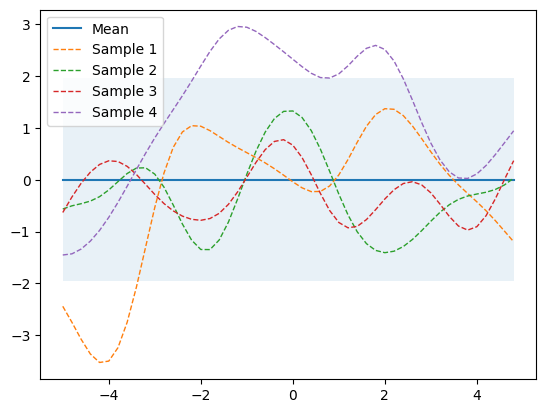

In [4]:
%matplotlib inline

# Finite number of points
X = np.arange(-5, 5, 0.2).reshape(-1, 1)

# TODO: Your code here
n, d = X.shape
cov = kernel(X,X)
samples = np.random.multivariate_normal(np.zeros(n), cov, 4)
plot_gp(np.zeros(X.shape), cov, X, samples=samples)

## Prediction from training data

In the following tasks, we will learn the `sine` function with GP and do regression tasks for data generated from both noise-free case

$$
\mathbf{y} = f(\mathbf{x}) = \text{sin}(\mathbf{x})
$$

and noisy case

$$
\mathbf{y} = f(\mathbf{x}) = \text{sin}(\mathbf{x}) + \mathbf{\epsilon},\, \mathbf{\epsilon} \sim \mathcal{N}(\mathbf{\epsilon}; \mathbf{0}, \mathbf{I}).
$$


In the lecture, we have seen shown how to compute the sufficient statistics, i.e., the mean and the covariance of the posterior predictive distribution for a new data point. Now, in this task, we generalize the posterior predictive distribution for multiple new data points.

A GP prior $p(\mathbf{f} \lvert \mathbf{X})$ can be converted into a GP posterior $p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})$ after having observed some data $\mathbf{y}$. The posterior can then be used to make predictions $\mathbf{f}_*$ given new input $\mathbf{X}_*$:

$$
\begin{align*}
p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{X},\mathbf{y}) 
&= \int{p(\mathbf{f}_* \lvert \mathbf{X}_*,\mathbf{f})p(\mathbf{f} \lvert \mathbf{X},\mathbf{y})}\ d\mathbf{f} \\ 
&= \mathcal{N}(\mathbf{f}_* \lvert \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)
\end{align*}
$$

By definition of the GP, the joint distribution of observed data $\mathbf{y}$ and predictions $\mathbf{f}_*$ is

$$
\begin{pmatrix}\mathbf{y} \\ \mathbf{f}_*\end{pmatrix} \sim \mathcal{N}
\left(\boldsymbol{0},
\begin{pmatrix}\mathbf{K}_y & \mathbf{K}_* \\ \mathbf{K}_*^T & \mathbf{K}_{**}\end{pmatrix}
\right)
$$


With $N$ training data and $N_*$ new input data, $\mathbf{K}_y = \kappa(\mathbf{X},\mathbf{X}) + \sigma_y^2\mathbf{I} = \mathbf{K} + \sigma_y^2\mathbf{I}$ is $N \times N$, $\mathbf{K}_* = \kappa(\mathbf{X},\mathbf{X}_*)$ is $N \times N_*$ and $\mathbf{K}_{**} = \kappa(\mathbf{X}_*,\mathbf{X}_*)$ is $N_* \times N_*$. $\sigma_y^2$ is the noise term in the diagonal of $\mathbf{K_y}$. It is set to zero if training targets are noise-free and to a value greater than zero if training observations are noisy. The mean is set to $\boldsymbol{0}$ for notational simplicity. The sufficient statistics of the posterior predictive distribution, $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$, can be computed by

$$
\begin{align*}
\boldsymbol{\mu_*} &= \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y} \\
\boldsymbol{\Sigma_*} &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*
\end{align*}
$$



 ### Exercise 3.2.3 
 Implement the below function that computes the predictive mean and variances. Apply them to both noise-free and noisy training data `X_train` and `Y_train`. Draw four samples from the predictive posterior and plot them along with the mean, confidence interval and training data. Why don't the samples go through the training data points in noisy case?

In [5]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n, d).
        X_train: Training locations (m, d).
        Y_train: Training targets (m, 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n, d) and covariance matrix (n, n).
    '''
    # TODO: Your code here
    n, d = X_s.shape
    m = X_train.shape[0]
    K = kernel(X_train, X_train,l,sigma_f) + (sigma_y**2) * np.identity(m)
    K_s = kernel(X_train, X_s,l,sigma_f)
    K_ss = kernel(X_s, X_s,l,sigma_f)
    mu = K_s.T @ np.linalg.inv(K) @ Y_train
    sigma = K_ss - (K_s.T @ np.linalg.inv(K) @ K_s)
    return mu, sigma

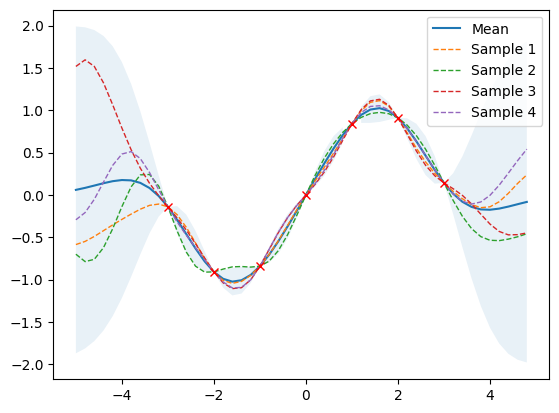

In [6]:
# Noise free training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train)

# TODO: Your code here
np.seterr(all="ignore")
mu, sigma = posterior_predictive(X, X_train, Y_train, sigma_y=0.0)
samples = np.random.multivariate_normal(mu.ravel(), sigma, 4)
plot_gp(mu, sigma, X, X_train, Y_train, samples=samples)

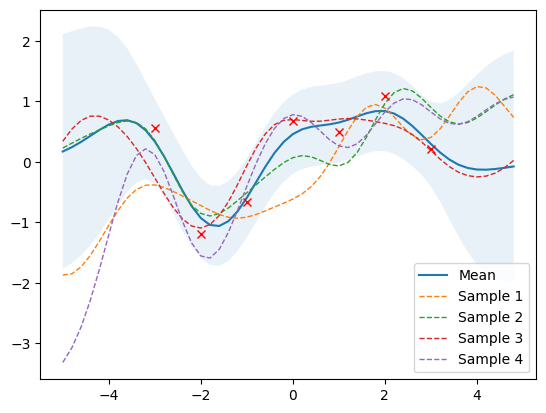

In [7]:
noise = 0.4

# Noisy training data
X_train = np.arange(-3, 4, 1).reshape(-1, 1)
Y_train = np.sin(X_train) + noise * np.random.randn(*X_train.shape)

# TODO: Your code here
mu, sigma = posterior_predictive(X, X_train, Y_train, sigma_y=noise)
samples = np.random.multivariate_normal(mu.ravel(), sigma, 4)
plot_gp(mu, sigma, X, X_train, Y_train, samples=samples)

---

`TODO: Your answer here`
The model knows whether or not the training data that it observes is noise-free or not. In the case of noise-free observations, the model is required to interpolate the observed data correctly. On the other hand, in the case of noisy observations of training points, the model is not required to interpolate the data correctly but rather it only needs to come close to the point, by incorporating the noise into the covariance matrix.

---

## Effect of kernel parameters and noise parameters

The following task shows the effect of kernel parameters $l$ and $\sigma_f$ as well as the noise parameter $\sigma_y$. Higher $l$ values lead to smoother functions and therefore to coarser approximations of the training data. Lower $l$ values make functions more wiggly with wide confidence intervals between training data points. $\sigma_f$ controls the vertical variation of functions drawn from the GP. This can be seen by the wide confidence intervals outside the training data region in the right figure of the second row. $\sigma_y$ represents the amount of noise in the training data. Higher $\sigma_y$ values make more coarse approximations which avoids overfitting to noisy data.

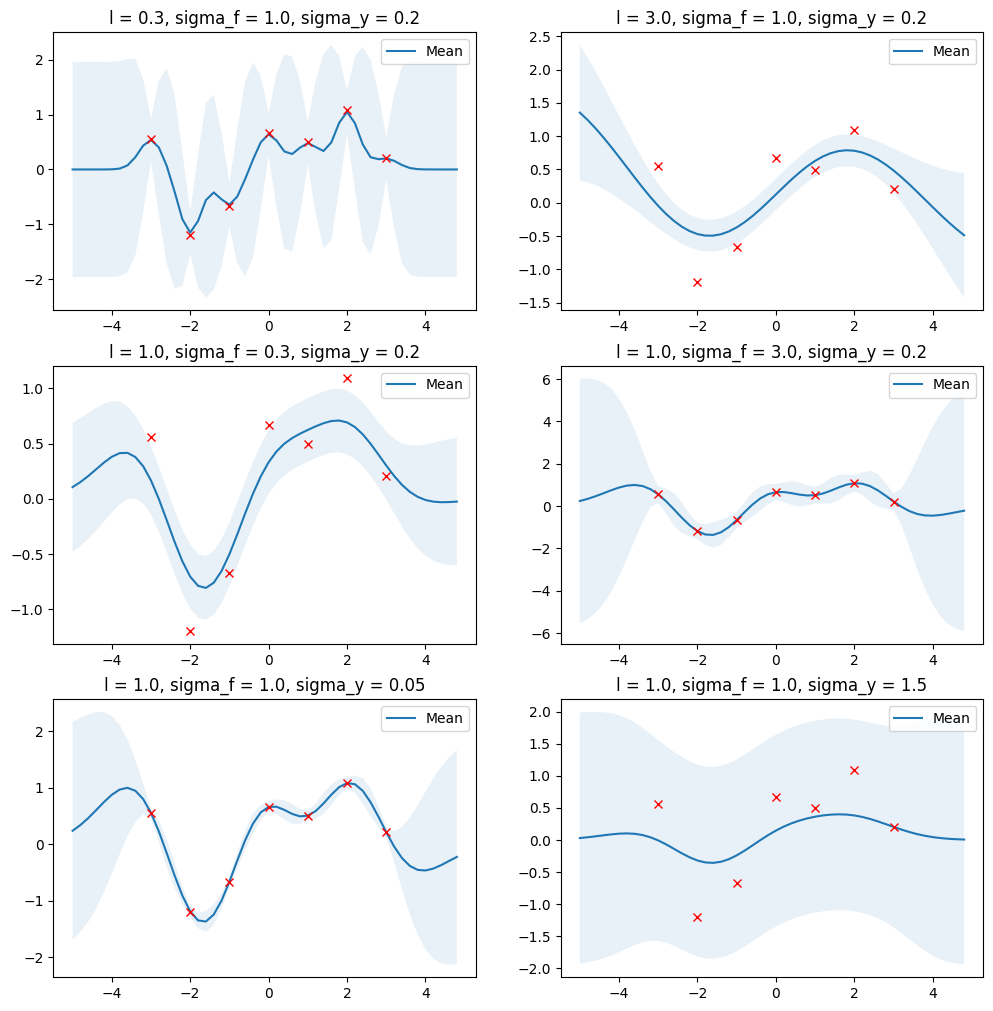

In [8]:
import matplotlib.pyplot as plt

params = [
    (0.3, 1.0, 0.2),
    (3.0, 1.0, 0.2),
    (1.0, 0.3, 0.2),
    (1.0, 3.0, 0.2),
    (1.0, 1.0, 0.05),
    (1.0, 1.0, 1.5),
]

plt.figure(figsize=(12, 5))

for i, (l, sigma_f, sigma_y) in enumerate(params):
    mu_s, cov_s = posterior_predictive(X, X_train, Y_train, l=l, 
                                       sigma_f=sigma_f, 
                                       sigma_y=sigma_y)
    plt.subplot(3, 2, i + 1)
    plt.subplots_adjust(top=2)
    plt.title(f'l = {l}, sigma_f = {sigma_f}, sigma_y = {sigma_y}')
    plot_gp(mu_s, cov_s, X, X_train=X_train, Y_train=Y_train)

Optimal values for these parameters can be estimated by maximizing the log marginal likelihood

$$
\log p(\mathbf{y} \lvert \mathbf{X}) = 
\log \mathcal{N}(\mathbf{y} \lvert \boldsymbol{0},\mathbf{K}_y) =
-\frac{1}{2} \mathbf{y}^T \mathbf{K}_y^{-1} \mathbf{y} 
-\frac{1}{2} \log \begin{vmatrix}\mathbf{K}_y\end{vmatrix} 
-\frac{N}{2} \log(2\pi)
$$

In this task, we will minimize the negative log marginal likelihood w.r.t. parameters $l$ and $\sigma_f$, $\sigma_y$ is set to the known noise level of the data. If the noise level is unknown, $\sigma_y$ can be estimated as well along with the other parameters. 

 ### Exercise 3.2.4 
 Implement the log likehood objective below. Then, given the noisy training data above, optimize for the parameters $\mathbf{\theta} = [l, \sigma_f, \sigma_y]$ w.r.t. the log likelihood objective. Finally, compute the predictive mean and variances with the optimized parameters and plot the result GP together with the training data.

**Hint:** see `scipy.optimize.minimize` [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html).

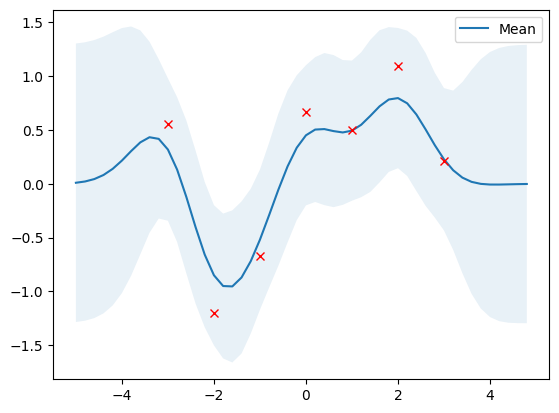

In [9]:
import scipy
from scipy.optimize import minimize

def nll_fn(X_train, Y_train, noise):
    '''
    Returns a function that computes the negative log marginal
    likelihood for training data X_train and Y_train and given 
    noise level.
    
    Args:
        X_train: training locations (m, d).
        Y_train: training targets (m, 1).
        noise: known noise level of Y_train.

    Returns:
        Minimization objective.
    '''
    def nll(theta):
        # TODO: Your code here
        l, sigma_f, sigma_y = theta
        if noise is not None:
            sigma_y = noise
        m, d = X_train.shape 
        K = kernel(X_train, X_train, l, sigma_f) + (sigma_y ** 2) * np.identity(m)
        return 0.5 * (Y_train.T @ np.linalg.inv(K) @ Y_train).ravel() \
                + 0.5 * np.log(np.linalg.det(K)) \
                + 0.5 * m * np.log(2 * np.pi)  # objective value
    return nll

# use scipy.optimize.minimize to minimize the parameters theta
# TODO: Your code here
opt_res = minimize(nll_fn(X_train, Y_train, noise), ((0.3, 1.0, noise)))
opt_l, opt_sigma_f, opt_sigma_y = opt_res.x
# compute the prosterior predictive statistics with optimized kernel parameters and plot the results
# TODO: Your code here
mu_opt, sigma_opt = posterior_predictive(X, X_train, Y_train, opt_l, opt_sigma_f, opt_sigma_y)
#samples = np.random.multivariate_normal(mu.ravel(), sigma_opt, 4)
plot_gp(mu_opt, sigma_opt, X, X_train, Y_train)

